### **Collision Avoidance MAC Protocol in Underwater Acoustic Sensor Network with Reinforcement Learning**

In [ ]:
import numpy as np  # Import the numpy library for numerical computations
from collections import deque  # Import the deque class from the collections module
from tensorflow.keras.models import Sequential  # Import the Sequential class from tensorflow.keras.models
from tensorflow.keras.layers import Dense  # Import the Dense class from tensorflow.keras.layers
from tensorflow.keras.optimizers import Adam  # Import the Adam class from tensorflow.keras.optimizers
import matplotlib.pyplot as plt  # Import the pyplot module from the matplotlib library
import networkx as nx  # Import the networkx library for network analysis and visualization
import time  # Import the time module for time-related operations
import os  # Import the os module for operating system related operations

M = 50  # State history length

# Define the Channel class
class Channel:
    def __init__(self):
        self.busy = False

    def is_free(self):
        return not self.busy

    def transmit(self):
        self.busy = True

    def reset(self):
        self.busy = False

# Define the Environment class
class Environment:
    def __init__(self, num_nodes, num_time_slots, M):
        self.num_nodes = num_nodes
        self.num_time_slots = num_time_slots
        self.channel = Channel()
        self.state_history = deque(maxlen=M)
        self.reset()

    def reset(self):
        self.state_history.clear()
        self.channel.reset()
        self.sender = np.random.randint(0, self.num_nodes)
        self.receiver = np.random.randint(0, self.num_nodes)
        self.state_history.extend([0] * (M - 1))
        self.state_history.append(1 if self.sender == self.receiver else 0)

        schedule = time_scheduling(self.num_nodes, self.num_time_slots)
        self.timeslot = schedule[self.sender]

        return np.array(self.state_history)

    def step(self, action):
        reward = 0
        done = False

        if action == 0:
            if self.channel.is_free():
                if self.receiver == self.sender:
                    reward = 1
                else:
                    reward = -2
                self.channel.transmit()
                self.update_states()
            else:
                reward = -3
        else:
            reward = 0
            self.update_states()

        self.state_history.append(reward)
        next_state = np.array(self.state_history)

        if len(self.state_history) == M:
            done = True

        return next_state, reward, done

    def update_states(self):
        self.sender = (self.sender + 1) % self.num_nodes
        if self.sender == 0:
            self.timeslot = (self.timeslot + 1) % self.num_time_slots
        self.receiver = np.random.randint(0, self.num_nodes)

        self.state_history.append(-1)  # Collision occurred
        if self.receiver == self.sender:
            self.state_history.append(1)  # Successful transmission
        else:
            self.state_history.append(0)  # No successful transmission

# Define the time scheduling algorithm
def time_scheduling(num_nodes, num_time_slots):
    schedule = {}
    for i in range(num_nodes):
        schedule[i] = np.random.randint(0, num_time_slots)
    return schedule

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # Discount rate
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.1
        self.model = self.build_model()

    def build_model(self):
        model = Sequential()  # Create a Sequential model
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))  # Add a Dense layer with 24 units and ReLU activation
        model.add(Dense(24, activation='relu'))  # Add another Dense layer with 24 units and ReLU activation
        model.add(Dense(self.action_size, activation='linear'))  # Add a Dense layer with 'action_size' units and linear activation
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))  # Compile the model with mean squared error loss and Adam optimizer
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)  # Return a random action
        act_values = self.model.predict(state)  # Get the predicted action values from the model
        return np.argmax(act_values[0])  # Return the index of the action with the highest value

    def replay(self, batch_size):
        minibatch = np.random.choice(len(self.memory), batch_size, replace=False)  # Select a random minibatch from memory
        for idx in minibatch:
            state, action, reward, next_state, done = self.memory[idx]
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))  # Calculate the target Q-value
            target_f = self.model.predict(state)  # Get the current Q-values
            target_f[0][action] = target  # Update the Q-value for the selected action
            self.model.fit(state, target_f, epochs=1, verbose=0)  # Train the model on the updated Q-value
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay  # Decay the exploration rate

def visualize_network(num_nodes):
    # Create a graph object
    graph = nx.Graph()
    # Add nodes to the graph
    graph.add_nodes_from(range(num_nodes))
    # Add edges to connect the nodes
    graph.add_edges_from([(i, i+1) for i in range(num_nodes-1)])
    # Plot the network
    pos = nx.spring_layout(graph)
    nx.draw_networkx(graph, pos)
    plt.title(f"Network with {num_nodes} Nodes")
    plt.show()

def visualize_time_scheduling(num_nodes, num_time_slots):
    schedule = time_scheduling(num_nodes, num_time_slots)  # Generate the time schedule using the time_scheduling algorithm
    x = list(range(num_time_slots))  # Create a list of time slots
    y = [schedule[i] + 1 for i in range(num_time_slots)]  # Create a list of corresponding node numbers for each time slot

    plt.plot(x, y, 'ro-', markersize=8)  # Plot the time schedule with red dots connected by lines
    plt.title(f"Time Scheduling for {num_nodes} Nodes and {num_time_slots} Time Slots")  # Set the title of the plot
    plt.xlabel("Time Slots")  # Set the label for the x-axis
    plt.ylabel("Node Number")  # Set the label for the y-axis
    plt.ylim(0, num_nodes + 1)  # Set the y-axis limits to include all node numbers
    plt.show()  # Display the plot


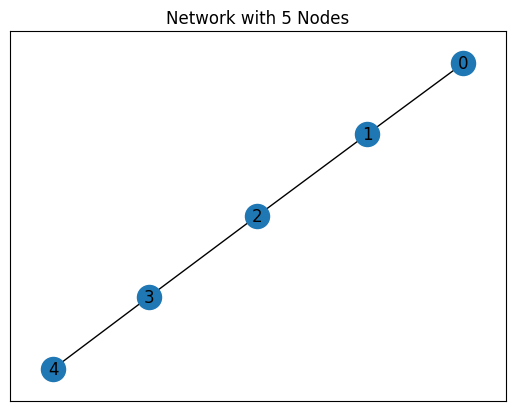

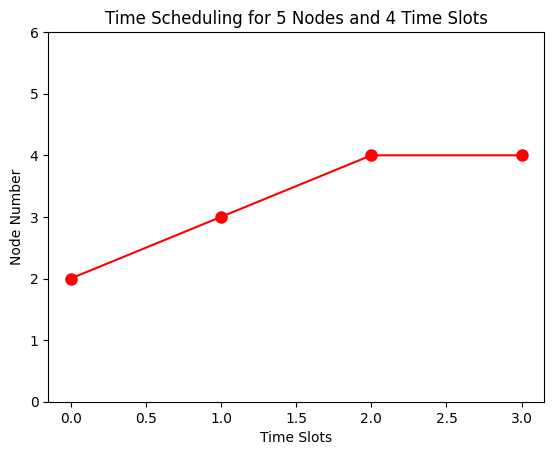

Streaming output truncated to the last 5000 lines.
Reward: -2
1/1 [==============================] - 0s 21ms/step
Episode 114: Total Reward = -2
Action: 0
State: [[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1
   1 -2]]
Next State: [[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1
   1 -2]]
Reward: -2
1/1 [==============================] - 0s 24ms/step
Episode 115: Total Reward = -2
Action: 0
State: [[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1
   0 -2]]
Next State: [[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1
   0 -2]]
Reward: -2
1/1 [==============================] - 0s 31ms/step
Episode 

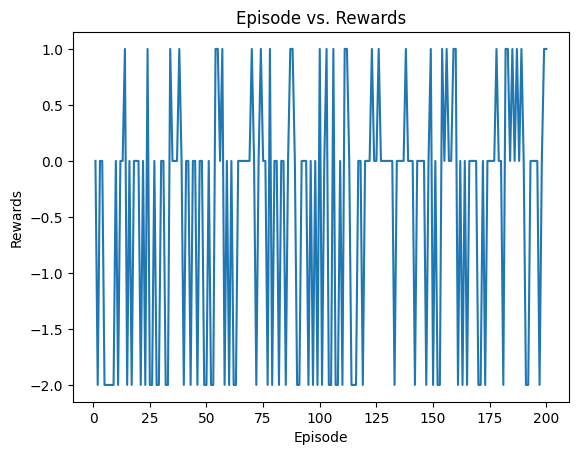

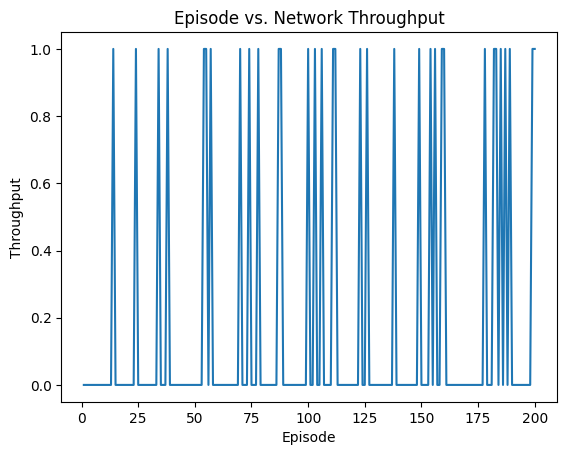

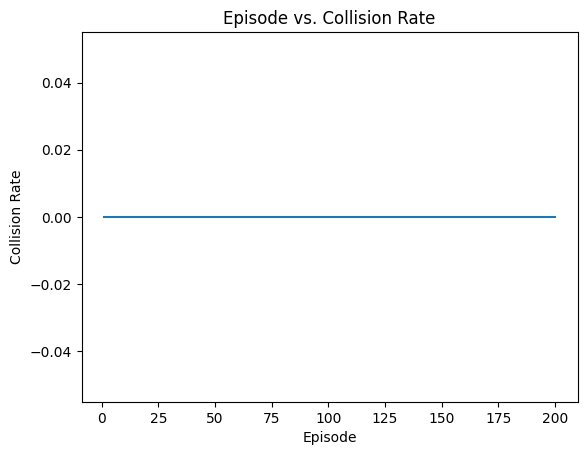

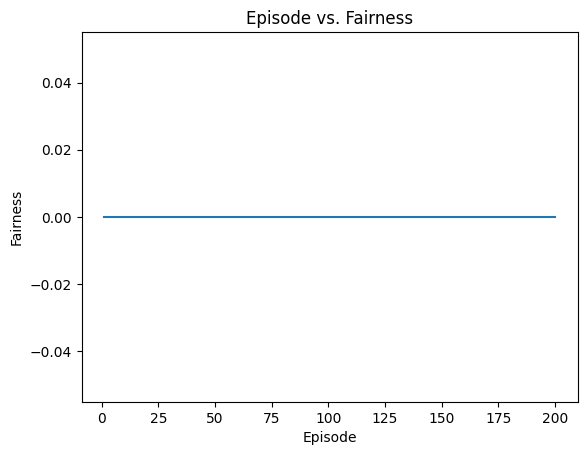

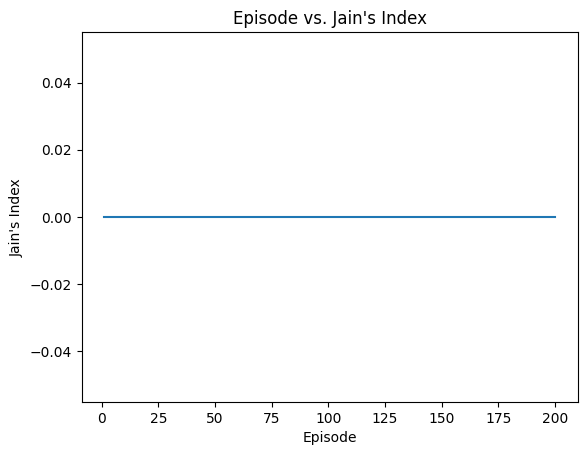

Trained model saved as dqn_model.h5


In [ ]:
# Training parameters
num_nodes = 5
num_time_slots = 4
num_episodes = 200
batch_size = 32

visualize_network(num_nodes)
visualize_time_scheduling(num_nodes, num_time_slots)

# Initialize the environment and agent
env = Environment(num_nodes, num_time_slots, M)
state_size = M
action_size = 2
agent = DQNAgent(state_size, action_size)


# Training loop
episode_rewards = []  # List to store episode rewards
collisions = 0  # Counter for collisions
fairness_denominator = 0
fairness_numerator=0
for episode in range(num_episodes):
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    done = False
    total_reward = 0

    while not done:
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        print("Action:", action)
        print("State:", state)
        print("Next State:", next_state)
        print("Reward:", reward)

    if len(agent.memory) > batch_size:
        agent.replay(batch_size)

    episode_rewards.append(total_reward)
    print(f"Episode {episode + 1}: Total Reward = {total_reward}")

# Calculate and display metrics
throughput_values = []  # List to store network throughput
collision_rate_values = []  # List to store collision rate
fairness_values = []  # List to store fairness values
jain_index_values = []  # List to store Jain's index values

for episode in range(num_episodes):
    episode_start_time = time.time()

    # Calculate network throughput
    successful_transmissions = np.sum(episode_rewards[episode] == 1)
    total_transmissions = np.sum(np.logical_or(episode_rewards[episode] == 1, episode_rewards[episode] == -2))
    throughput = 0 if total_transmissions == 0 else successful_transmissions / total_transmissions
    collision_rate = 0 if total_transmissions == 0 else collisions / total_transmissions

    # Calculate fairness and Jain's index
    fairness = (fairness_numerator / num_nodes) ** 2 / (fairness_denominator / (num_nodes ** 2)) if fairness_denominator != 0 else 0
    jain_index = (fairness_numerator ** 2) / (num_nodes * fairness_denominator) if fairness_denominator != 0 else 0

    # Handle invalid values
    if np.isnan(throughput):
        throughput = 0
    if np.isnan(collision_rate):
        collision_rate = 0
    if np.isnan(fairness):
        fairness = 0
    if np.isnan(jain_index):
        jain_index = 0

    # Append metrics to lists
    throughput_values.append(throughput)
    collision_rate_values.append(collision_rate)
    fairness_values.append(fairness)
    jain_index_values.append(jain_index)

    #print(f"Episode {episode + 1} Time: {episode_time} seconds")
    print("Reward:", episode_rewards[episode])
    print("State:", state)
    print("Next State:", next_state)

# Save the trained model
model_filename = "dqn_model.h5"
agent.model.save(model_filename)
print(f"Trained model saved as {model_filename}")

# Plot episode vs. rewards
plt.plot(range(1, num_episodes + 1), episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Rewards")
plt.title("Episode vs. Rewards")
plt.show()

# Plot episode vs. network throughput
plt.plot(range(1, num_episodes + 1), throughput_values)
plt.xlabel("Episode")
plt.ylabel("Throughput")
plt.title("Episode vs. Network Throughput")
plt.show()

# Plot episode vs. collision rate
plt.plot(range(1, num_episodes + 1), collision_rate_values)
plt.xlabel("Episode")
plt.ylabel("Collision Rate")
plt.title("Episode vs. Collision Rate")
plt.show()

# Plot episode vs. fairness
plt.plot(range(1, num_episodes + 1), fairness_values)
plt.xlabel("Episode")
plt.ylabel("Fairness")
plt.title("Episode vs. Fairness")
plt.show()

# Plot episode vs. Jain's index
plt.plot(range(1, num_episodes + 1), jain_index_values)
plt.xlabel("Episode")
plt.ylabel("Jain's Index")
plt.title("Episode vs. Jain's Index")
plt.show()


# Save the trained model
model_filename = "dqn_model.h5"
agent.model.save(model_filename)
print(f"Trained model saved as {model_filename}")


Over all working:
**Channel class:** This class represents a communication channel. It has methods to check if the channel is free, transmit data, and reset the channel.

**Environment class:** This class represents the communication environment. It initializes the state history, channel, sender, receiver, and time slot. It has methods to reset the environment, perform a step (transmit or not transmit), and update the states.

**time_scheduling function:** This function implements a time scheduling algorithm. It takes the number of nodes and the number of time slots as input and generates a schedule for the nodes.

**DQNAgent class: **This class represents the DQN agent. It initializes the state size, action size, memory, discount rate, exploration rate, learning rate, and the neural network model. It has methods to build the model, store experiences in memory, select actions, replay experiences, and update the exploration rate.

**visualize_network function:** This function visualizes the network graph using the networkx and matplotlib libraries. It creates a graph object, adds nodes and edges, and plots the network.

**visualize_time_scheduling function:** This function visualizes the time scheduling for the nodes. It generates a time schedule using the time_scheduling algorithm and plots it using matplotlib.

**Training parameters:** The code starts by setting the parameters for training, such as the number of nodes, number of time slots, number of episodes, and batch size.

**Visualization:** The code calls the visualize_network and visualize_time_scheduling functions to plot the network graph and time scheduling for visualization purposes.

**Environment and Agent Initialization: **The code initializes the communication environment (env) with the specified number of nodes, number of time slots, and state history length. It also initializes the DQN agent (agent) with the state size, action size, and builds the neural network model.

**Training Loop: ** The code enters a loop over the specified number of episodes. In each episode:

The environment is reset, and the initial state is obtained.
The state is reshaped and the done flag is set to False.
The agent interacts with the environment until the episode is done:
The agent selects an action based on the current state using the act method.
The action is applied to the environment using the step method, and the next state, reward, and done flag are obtained.
The experience (state, action, reward, next_state, done) is stored in the agent's memory using the remember method.
The state is updated to the next state.
The total reward for the episode is updated.
If the agent's memory contains enough experiences, the agent replays a batch of experiences using the replay method, which updates the neural network model based on the Q-learning algorithm.
The total reward for the episode is appended to the episode_rewards list.
Metrics Calculation: After the training loop, the code calculates various metrics based on the episode rewards. It calculates the network throughput, collision rate, fairness, and Jain's index for each episode. These metrics are stored in separate lists.



**Model Saving:** The trained model is saved to a file using the save method of the agent's model.

**Plotting:** The code plots several graphs to visualize the training progress. It plots the episode vs. rewards, episode vs. network throughput, episode vs. collision rate, episode vs. fairness, and episode vs. Jain's index.

**Model Saving (Again):** The trained model is saved to a file again for redundancy.

Define the Reward Function:
The reward received by each agent at time t will depend on the outcome of the transmission in that time slot.
If the access point successfully receives a packet, the reward for the corresponding agent is 1.
If the access point remains silent (no successful packet reception), the reward for the agent is 0.
If a receive-receive collision occurs, the reward is -1.
If a send-receive collision occurs, the reward is -2.
If packet crosstalk occurs, the reward is -3.
